In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from konlpy.tag import Komoran

In [2]:
movie = pd.read_csv("../../datasets/영화리뷰데이터.csv")
purpose = pd.read_csv("../../datasets/용도별목적대화데이터.csv")
topic = pd.read_csv("../../datasets/주제별일상대화데이터.csv")
common_sense = pd.read_csv("../../datasets/일반상식데이터.csv")
add = pd.read_csv("../../datasets/추가데이터.csv")

movie.dropna(inplace=True)
purpose.dropna(inplace=True)
topic.dropna(inplace=True)
common_sense.dropna(inplace=True)
add.dropna(inplace=True)

In [3]:
print(f"movie shape => {movie.shape}")
print(f"purpose shape => {purpose.shape}")
print(f"topic shape => {topic.shape}")
print(f"common_sense shape => {common_sense.shape}")
print(f"add shape => {add.shape}")

movie shape => (199992, 3)
purpose shape => (480494, 1)
topic shape => (1445760, 1)
common_sense shape => (68538, 3)
add shape => (9216, 2)


In [4]:
all_data = list(movie["document"] ) + list(purpose["text"]) + list(topic["text"]) + list(common_sense["query"]) + list(common_sense["answer"]) + list(add["query"])

print(all_data[0:5])
print(len(all_data))

['어릴때보고 지금다시봐도 재밌어요ㅋㅋ', '디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데. 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다.', '폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.', '와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런게 진짜 영화지', '안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.']
2272538


In [5]:
total_data = pd.DataFrame({"text": all_data})
total_data.to_csv("../../datasets/통합데이터.csv", index=False)

### 의도 분류 데이터 생성

0 -> 번호, 1 -> 장소, 2-> 일정, 3 -> 메뉴, 4 -> 기타

In [6]:
number = []
place = []
time = []
menu = []
etc = []

In [7]:
for i in all_data :
    if ("번호" or "전화") in i : 
        number.append(i)
    
    elif ("어디" or "장소" or "위치" or "주소") in i :
        place.append(i)
        
    elif ("시작" or "마감" or "언제" or "기간" or "시간") in i :
        time.append(i)
    
    elif ("식사" or "밥" or "메뉴" or "추천") in i :
        menu.append(i)
    
    else : etc.append(i)

In [8]:
print(len(number))

number_label = []
for _ in range(len(number)) :
    number_label.append(0)
    
print(len(number_label))

12588
12588


In [9]:
print(len(place))

place_label = []
for _ in range(len(place)) :
    place_label.append(1)
    
print(len(place_label))

29260
29260


In [10]:
print(len(time))

time_label = []
for _ in range(len(time)) :
    time_label.append(2)
    
print(len(time_label))

8332
8332


In [11]:
print(len(menu))

menu_label = []
for _ in range(len(menu)) :
    menu_label.append(3)
    
print(len(menu_label))

1337
1337


In [12]:
train_df = pd.DataFrame({"text" : number+place+time+menu,
                         "label" : number_label+place_label+time_label+menu_label})

train_df.head()

,text,label
0,이 영화 있는사람 공유 부탁합니다 제 폰번호 010 4427 2774 연락한통만요^-^;,0
1,작가때문에 1점 주려다가 영화가 너무 좋아서 10점줌비행기를 끌고 추운곳에다 추락시...,0
2,비밀번호가 뭐야? 서윤내사랑 ㅋ_ㅋ,0
3,용팔이 시르즈를 볼려면 어떻게 하는지.전화번호좀,0
4,보다 말았는데 심장 졸라 쫄깃해진다;; 근데 여주 졸라 답답함. 세면대 물기 닦는 ...,0


In [13]:
train_df.tail()

,text,label
51512,팀장님과 점심 식사 일정 언제니,3
51513,내일 저녁 식사 약속이 언제니,3
51514,오늘 점심식사 예약 시간 언제인지 확인해라,3
51515,가족 식사는 언제 하기로 했었니,3
51516,내일 교수님과 식사 언제부터니,3


In [14]:
train_df.reset_index(drop=True, inplace=True)

In [15]:
train_df.to_csv("train_data.csv")

### 적절한 패딩 길이 구하기

In [16]:
data = pd.read_csv("train_data.csv")

In [17]:
data.shape

(51517, 3)

In [18]:
tokenizer = Komoran()

In [19]:
data_tokenized = [[token + "/" + POS for token, POS in tokenizer.pos(text_)] for text_ in data['text']]

exclusion_tags = [
            'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ',
            'JX', 'JC',
            'SF', 'SP', 'SS', 'SE', 'SO',
            'EP', 'EF', 'EC', 'ETN', 'ETM',
            'XSN', 'XSV', 'XSA'
]

f = lambda x: x in exclusion_tags

data_list = []
for i in range(len(data_tokenized)):
        temp = []
        for j in range(len(data_tokenized[i])):
            if f(data_tokenized[i][j].split('/')[1]) is False:
                temp.append(data_tokenized[i][j].split('/')[0])
        data_list.append(temp)

In [20]:
data_list[0]

['이',
 '영화',
 '있',
 '사람',
 '공유',
 '부탁',
 '제',
 '폰',
 '번호',
 '010',
 '4427',
 '2774',
 '연락',
 '한통',
 '만요',
 '^',
 '^']

In [21]:
num_tokens = [len(tokens) for tokens in data_list]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

토큰 길이 평균: 7.609313430518082
토큰 길이 최대: 69
토큰 길이 표준편차: 5.011374858328802


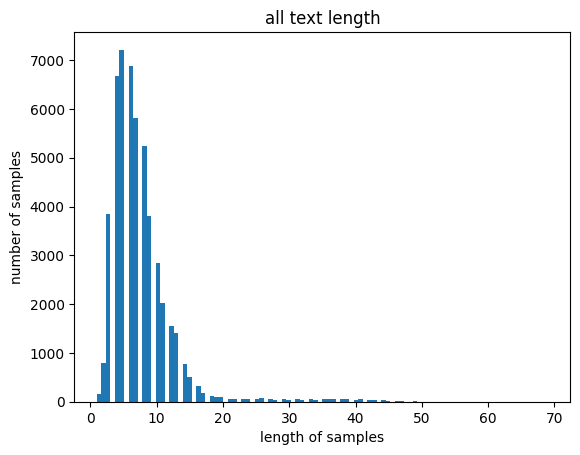

In [22]:
plt.title('all text length')
plt.hist(num_tokens, bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [23]:
select_length = 25

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
        
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
    
below_threshold_len(select_length, data_list)

전체 샘플 중 길이가 25 이하인 샘플의 비율: 0.982840615719083
